In [32]:
%matplotlib inline
import astropy.units as u
import astropy.io.fits as fits
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import vip_hci as vip
from hciplot import plot_frames, plot_cubes
import pyds9 as sao

In [2]:
from packaging import version
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import normalize_psf
    from vip_hci.pca import pca
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import normalize_psf
    from vip_hci.psfsub import median_sub, pca

# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap, contrast_curve, detection, throughput 
from vip_hci.var import fit_2dgaussian, frame_center
from vip_hci.preproc import (approx_stellar_position, cube_correct_nan, cube_crop_frames,
                             cube_detect_badfr_correlation, cube_fix_badpix_annuli,
                             cube_fix_badpix_clump, cube_fix_badpix_isolated,
                             cube_px_resampling, cube_recenter_2dfit, cube_recenter_dft_upsampling,
                             cube_recenter_satspots, cube_recenter_via_speckles, cube_shift,
                             frame_center_radon, frame_crop, frame_fix_badpix_isolated)

VIP version:  1.4.0


In [3]:
#ds9 = vip.Ds9Window()

In [4]:
# Let’s first inspect the fits file
info_fits('/home/cvargas/sphere/AS209/data_K1_obj.fits')

Filename: /home/cvargas/sphere/AS209/data_K1_obj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (1024, 1024, 32)   float32   


In [5]:
# Now we load all the data in memory with the open_fits function
cubename = '/home/cvargas/sphere/AS209/data_K1_obj.fits'
anglename = '/home/cvargas/sphere/AS209/ird_convert_recenter_dc2021-IRD_SCIENCE_PARA_ROTATION_CUBE-rotnth.fits'

cube = open_fits('/home/cvargas/sphere/AS209/data_K1_obj.fits')
angle = open_fits('/home/cvargas/sphere/AS209/ird_convert_recenter_dc2021-IRD_SCIENCE_PARA_ROTATION_CUBE-rotnth.fits')

Fits HDU-0 data successfully loaded. Data shape: (32, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (32,)


In [6]:
hdu = fits.open(cubename)

In [7]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                   32                                                  
EXTEND  =                    T                                                  

In [6]:
angle

array([-20.327301  , -20.218826  , -20.096222  , -19.982513  ,
       -19.854256  , -19.735107  , -19.600746  , -19.475891  ,
       -17.175224  , -16.995262  , -16.79512   , -16.606415  ,
       -16.393845  , -16.195816  , -15.975601  , -15.767822  ,
       -10.924171  , -10.593399  , -10.21962   ,  -9.871208  ,
        -9.482689  ,  -9.115486  ,  -8.699844  ,  -8.312508  ,
        -1.5937805 ,  -1.017273  ,  -0.36183167,   0.24732971,
         0.9362793 ,   1.5805054 ,   2.2996979 ,   2.9806824 ],
      dtype=float32)

New shape: (32, 100, 100)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[100, 100, 32]


:HoloMap   [time]
   :Image   [x,y]   (flux)
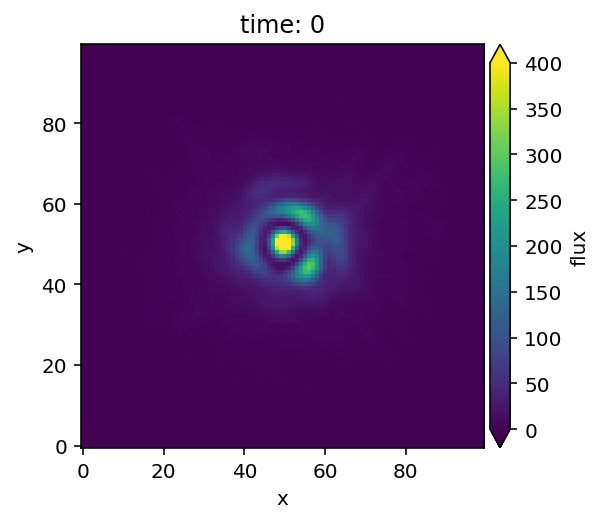
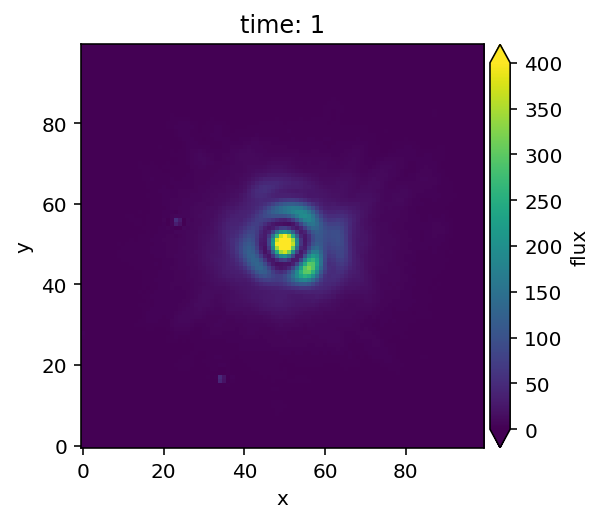
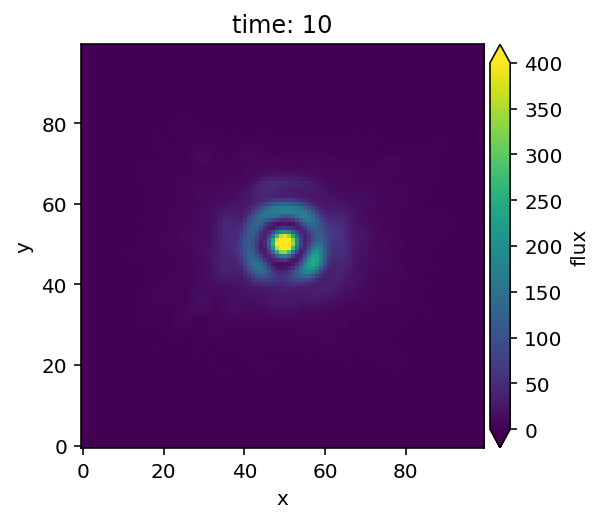
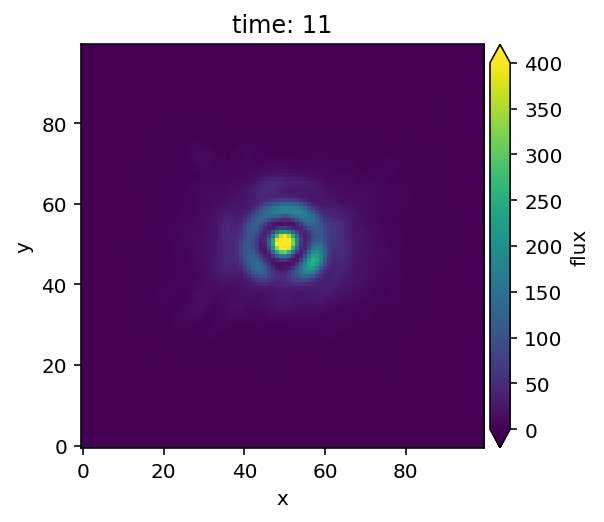
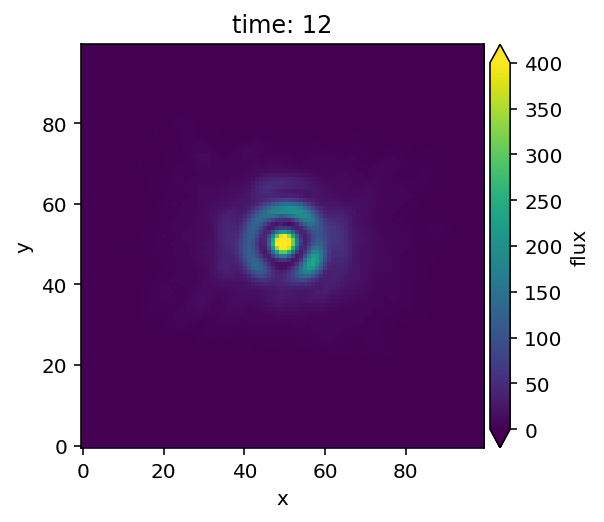
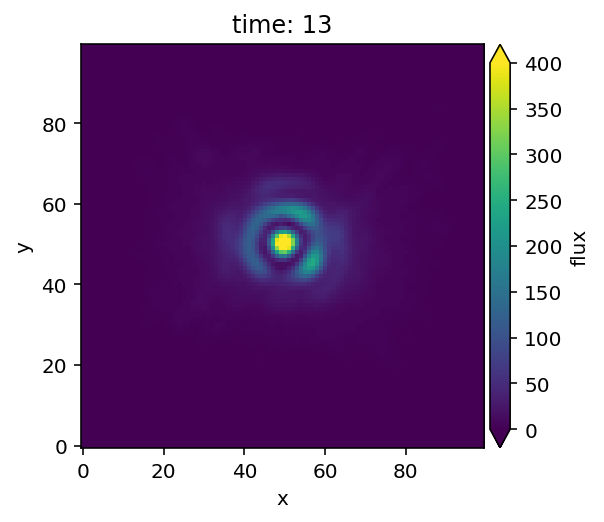
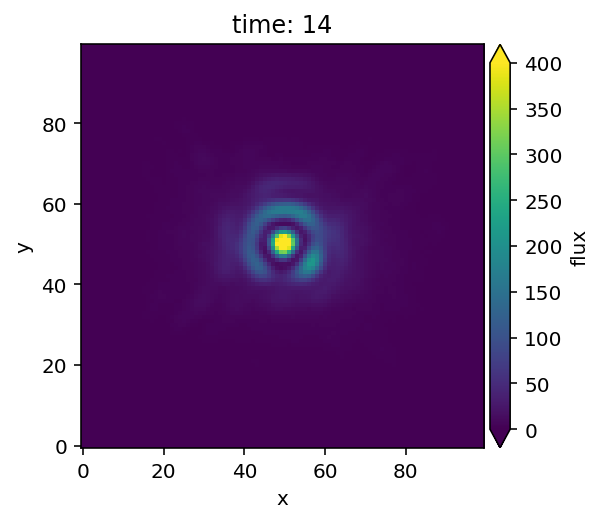
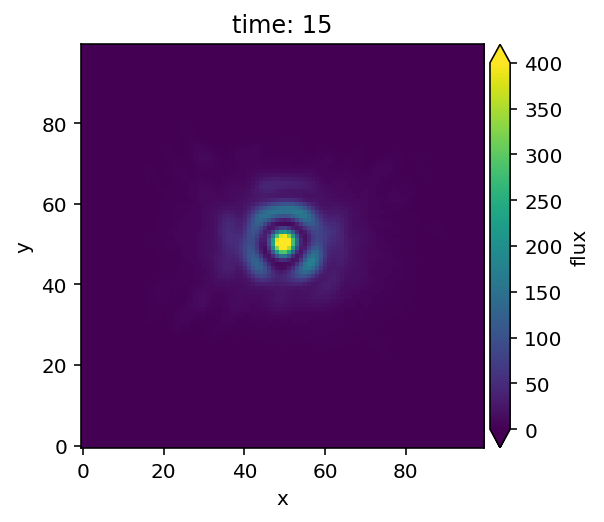
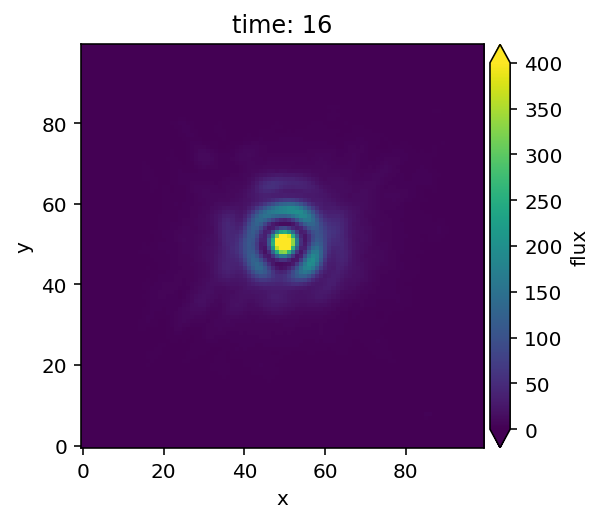
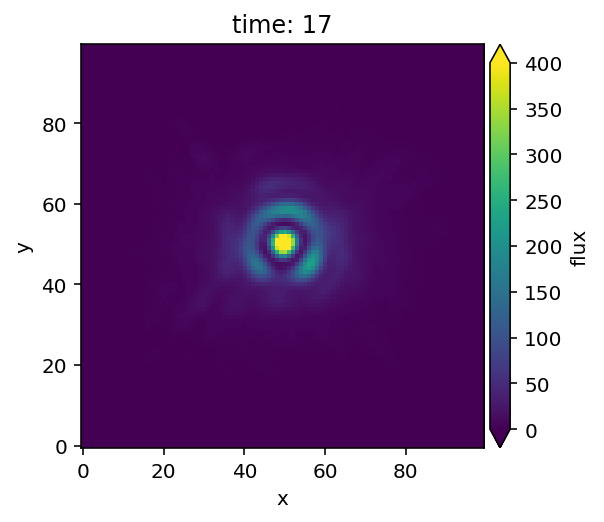
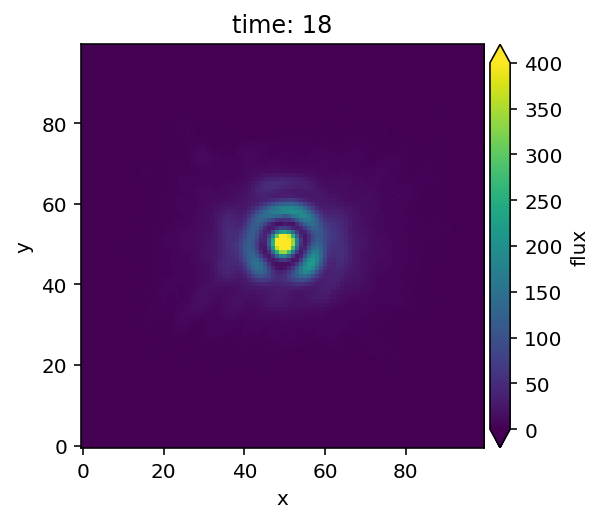
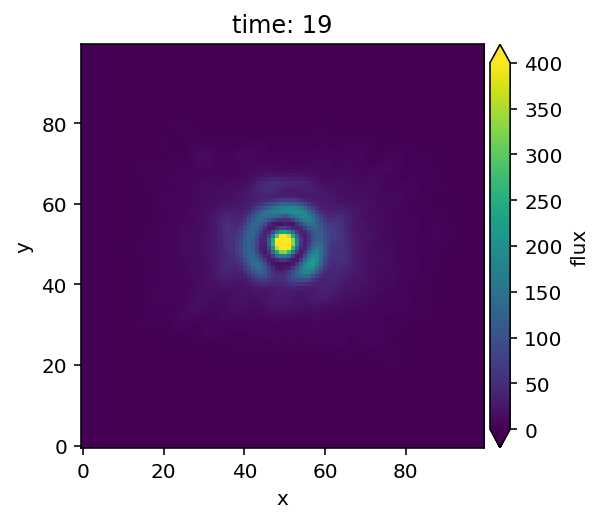
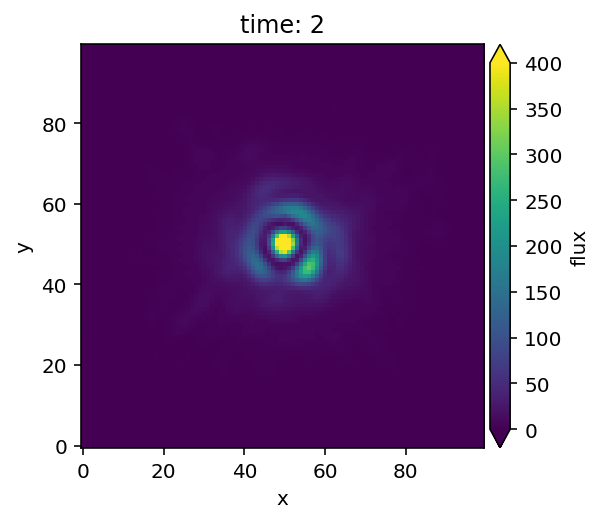
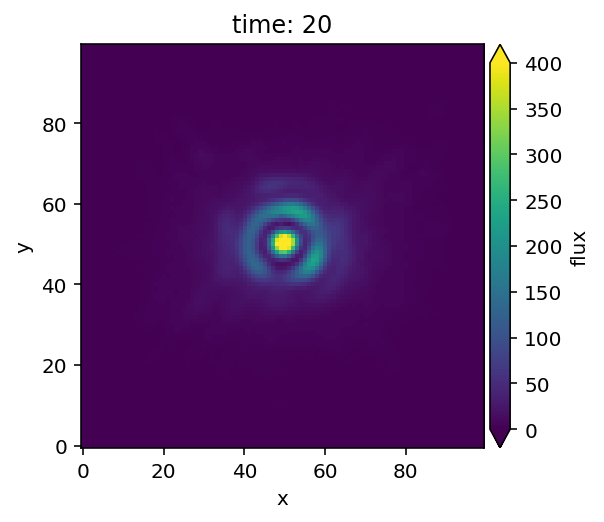
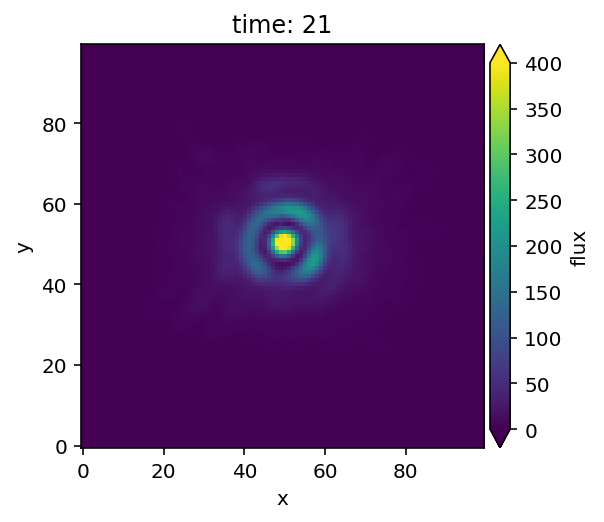
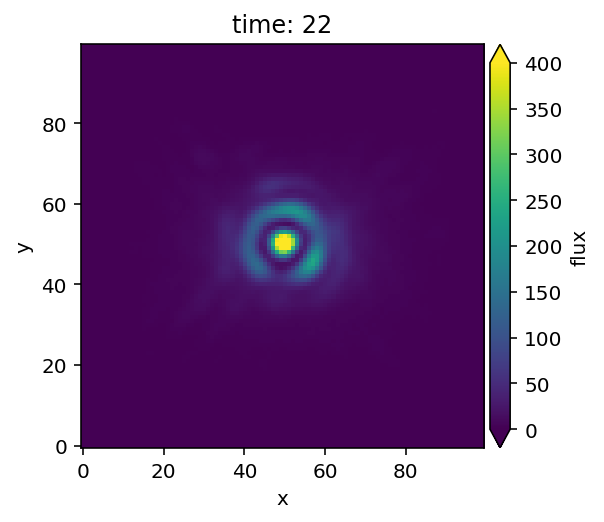
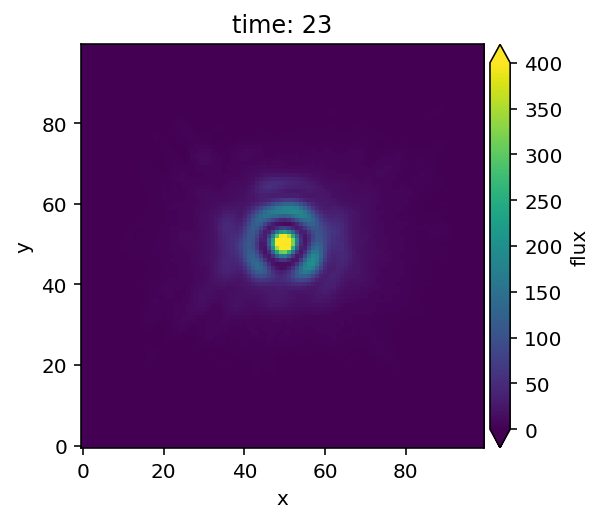
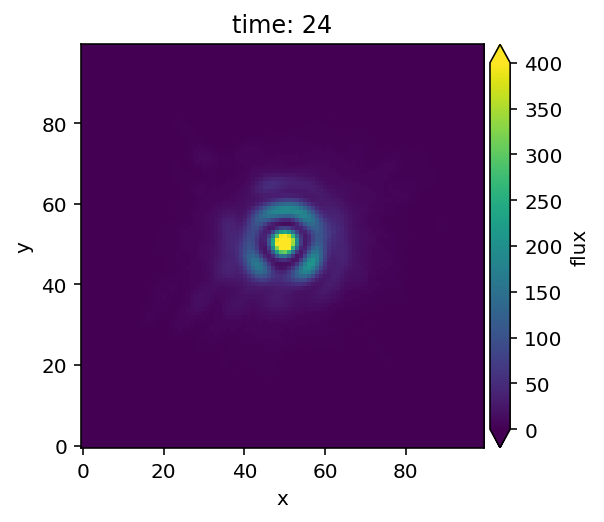
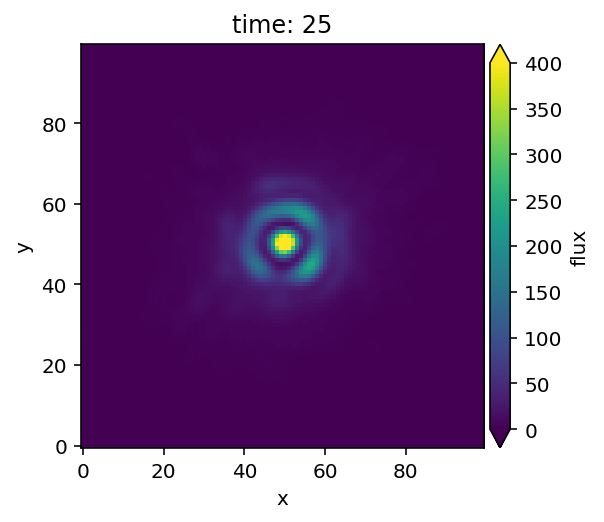
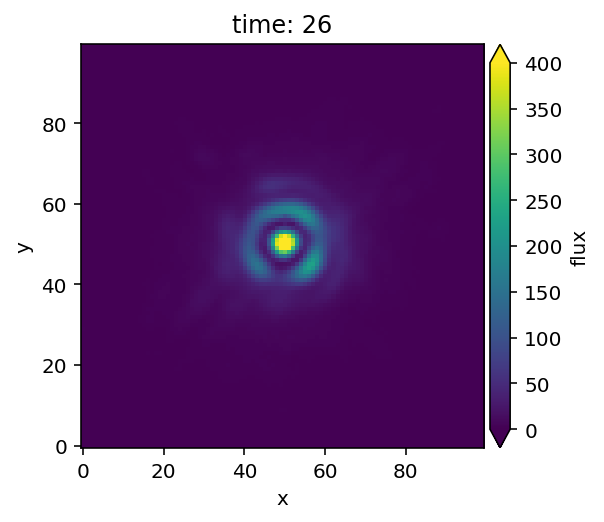
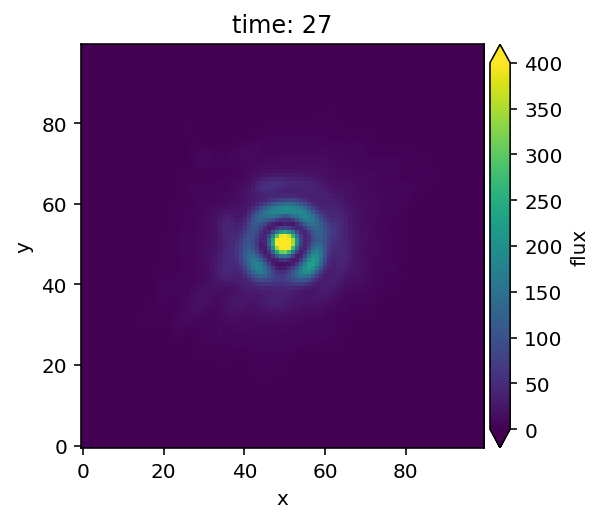
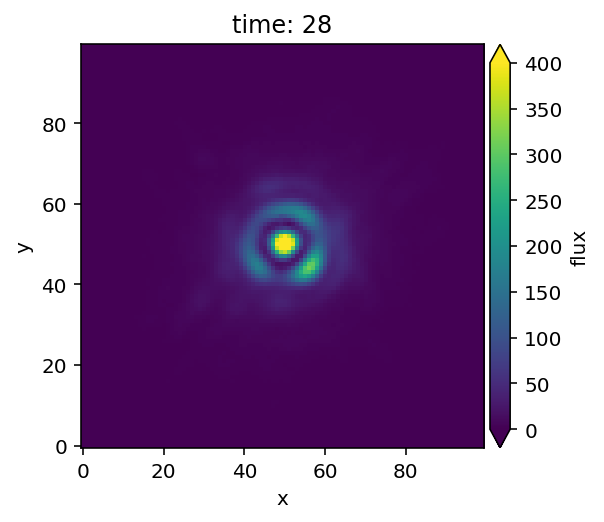
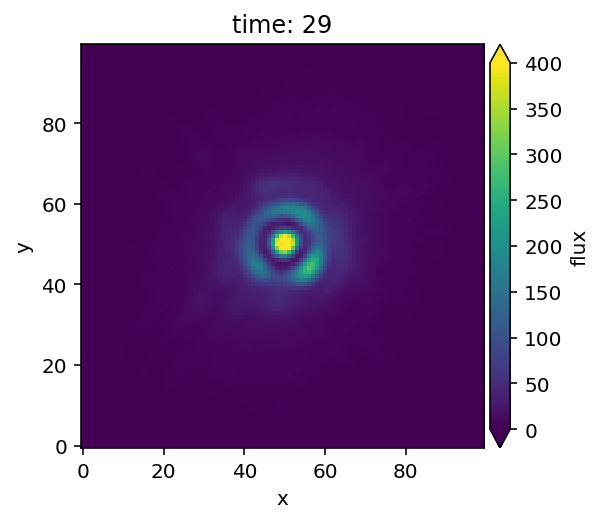
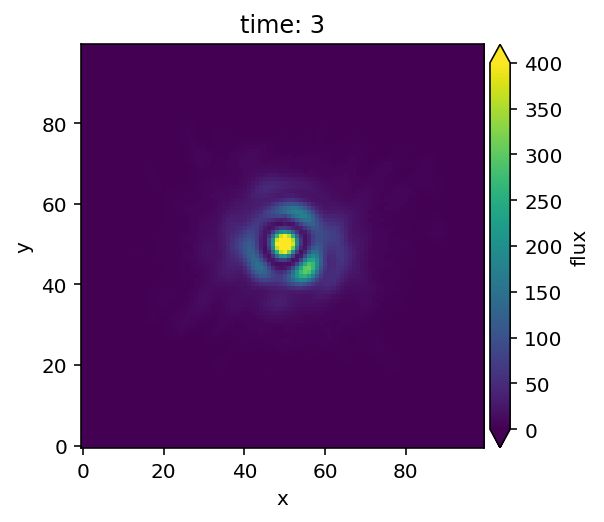
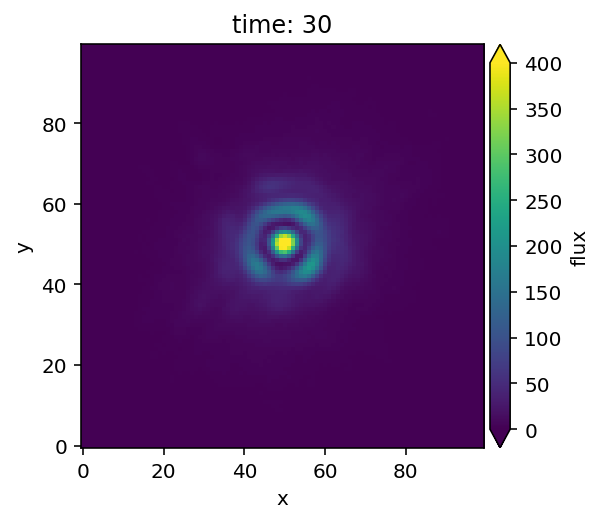
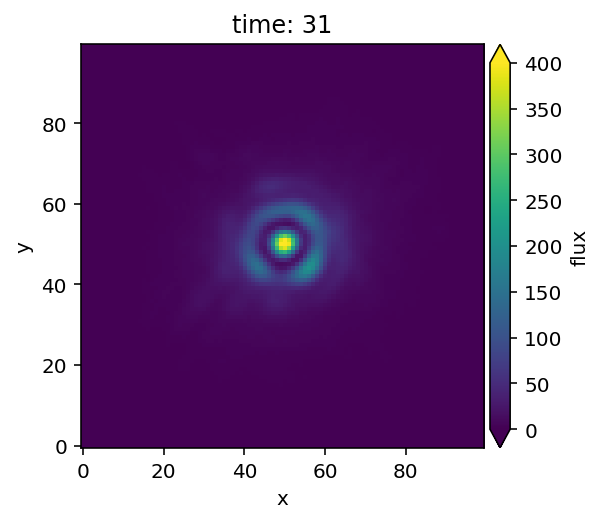
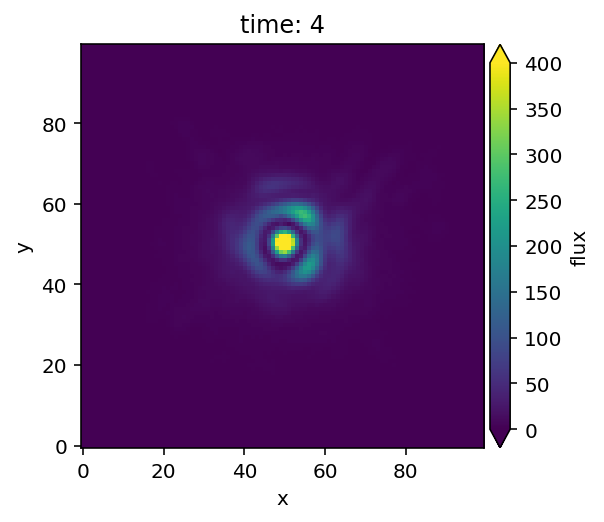
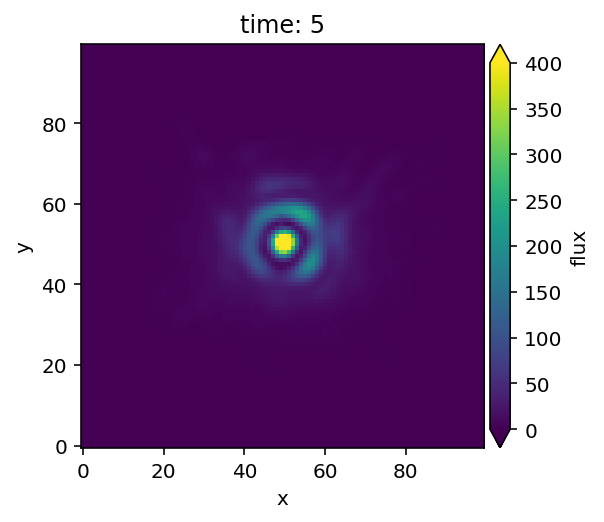
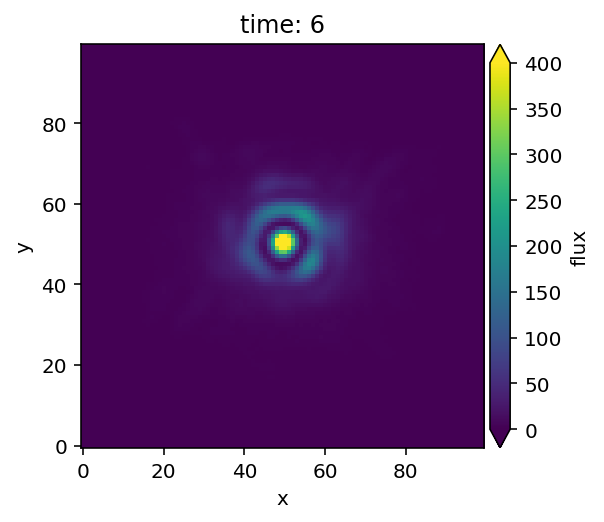
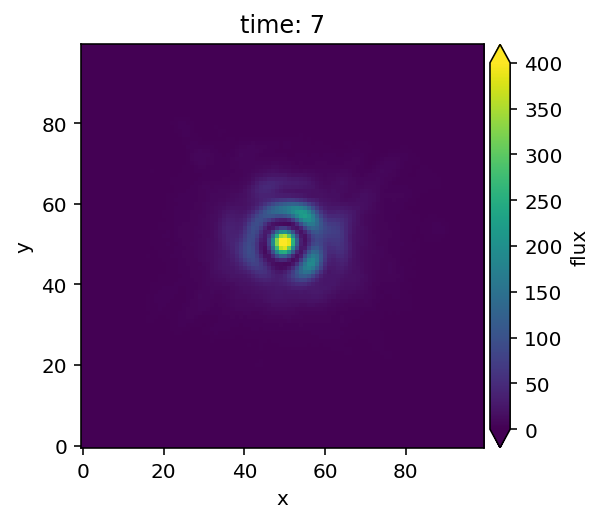
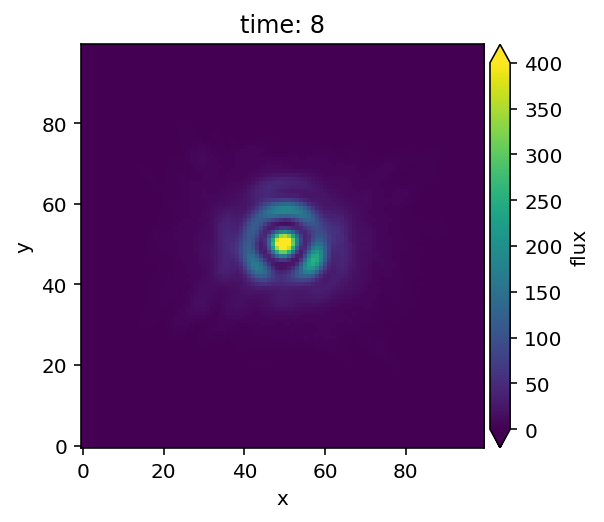
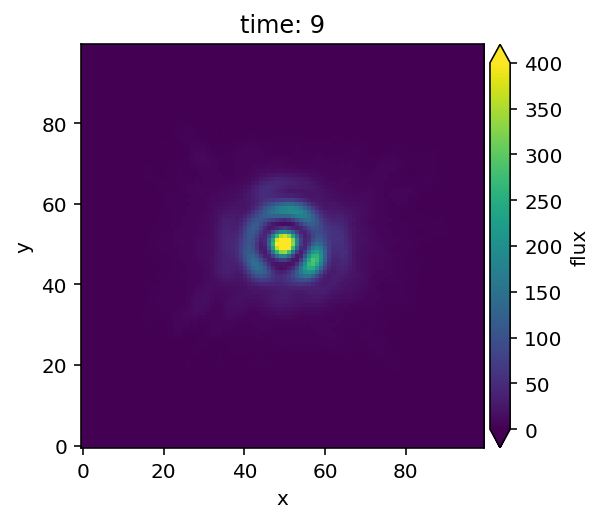
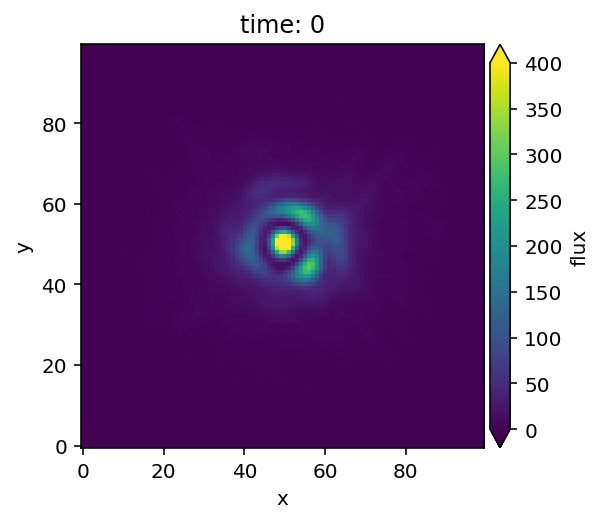

In [7]:
plot_cubes(cube_crop_frames(cube,100), dynamic=False, vmin=0, vmax=400)


In [8]:
imlib = 'vip-fft'
interpolation=None

### Median

In [9]:
fr_adi = median_sub(cube, angle, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-04-15 16:21:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:04:43.625685
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [10]:
fr_adi_an = median_sub(cube, angle, mode='annular', imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-04-15 16:26:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 128, FWHM = 4
PA threshold 90.00 is likely too big, will be set to 10.49
PA threshold 36.87 is likely too big, will be set to 10.49
PA threshold 22.62 is likely too big, will be set to 10.49
PA threshold 16.26 is likely too big, will be set to 10.49
PA threshold 12.68 is likely too big, will be set to 10.49
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:05:31.821072
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [11]:
help(median_sub)

Help on function median_sub in module vip_hci.psfsub.medsub:

median_sub(cube, angle_list, scale_list=None, flux_sc_list=None, fwhm=4, radius_int=0, asize=4, delta_rot=1, delta_sep=(0.1, 1), mode='fullfr', nframes=4, sdi_only=False, imlib='vip-fft', interpolation='lanczos4', collapse='median', nproc=1, full_output=False, verbose=True, **rot_options)
    Implementation of a median subtraction algorithm for model PSF
    subtraction in high-contrast imaging sequences. In the case of ADI, the
    algorithm is based on [MAR06]_. The ADI+IFS method is an extension of this
    basic idea to multi-spectral cubes.
        
    References: [MAR06]_ for median-ADI; [SPA02]_ and [THA07]_ for SDI.
    
    Parameters
    ----------
    cube : numpy ndarray, 3d
        Input cube.
    angle_list : numpy ndarray, 1d
        Corresponding parallactic angle for each frame.
    scale_list : numpy ndarray, 1d, optional
        If provided, triggers mSDI reduction. These should be the scaling
        fac

In [12]:
help(plot_frames)

Help on function plot_frames in module hciplot.hciplot:

plot_frames(data, backend='matplotlib', mode='mosaic', rows=1, vmax=None, vmin=None, circle=None, circle_alpha=0.8, circle_color='white', circle_linestyle='-', circle_radius=6, circle_label=False, circle_label_color='white', arrow=None, arrow_alpha=0.8, arrow_length=10, arrow_shiftx=5, arrow_label=None, label=None, label_pad=5, label_size=12, label_color='white', grid=False, grid_alpha=0.4, grid_color='#f7f7f7', grid_spacing=None, cross=None, cross_alpha=0.4, lab_fontsize=8, cross_color='white', ang_scale=False, ang_ticksep=50, tick_direction='out', tick_color='black', ndec=1, pxscale=0.01, auscale=1.0, ang_legend=False, au_legend=False, axis=True, show_center=False, cmap=None, log=False, colorbar=True, top_colorbar=False, colorbar_ticks=None, colorbar_ticksize=8, colorbar_label='', colorbar_label_size=8, patch=None, dpi=100, size_factor=6, horsp=0.4, versp=0.2, width=400, height=400, title=None, tit_size=16, sampling=1, save=Non

New shape: (210, 210)
New shape: (210, 210)


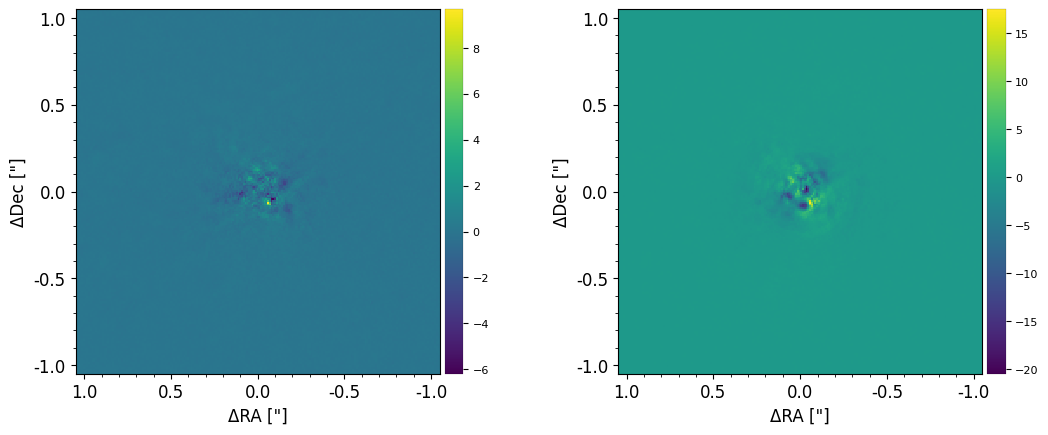

In [13]:
%matplotlib inline
plot_frames((frame_crop(fr_adi, 210),frame_crop(fr_adi_an, 210)), backend='matplotlib', ang_scale=True)

### PCA

In [14]:
fr_pca1 = pca(cube, angle, ncomp=5, mask_center_px=None, imlib=imlib, interpolation=interpolation,
              svd_mode='lapack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-04-15 16:31:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 134.824 GB
System available memory = 119.979 GB
Done vectorizing the frames. Matrix shape: (32, 1048576)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:03.553241
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:04:55.371740
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


New shape: (100, 100)


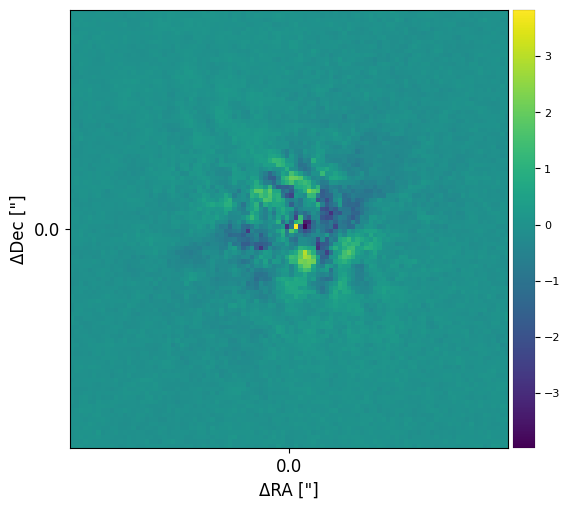

In [18]:
plot_frames((frame_crop(fr_pca1, 110)), backend='matplotlib', ang_scale=True, grid=True)

### Throughput

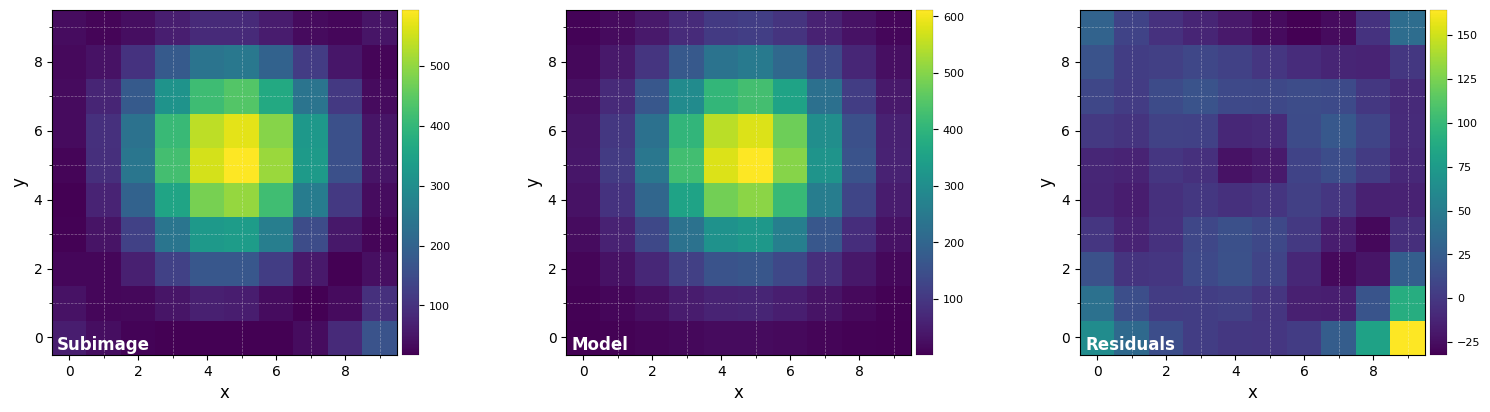

FWHM_y = 4.770809136349241
FWHM_x = 4.666432750209739 

centroid y = 512.2775467470417
centroid x = 511.71262421549585
centroid y subim = 5.2775467470417
centroid x subim = 4.712624215495854 

amplitude = 624.0085729431335
theta = -20.892915691482703


In [8]:
%matplotlib inline
DF_fit = fit_2dgaussian(cube[0], crop=True, cropsize=9, debug=True, full_output=True)

In [9]:
fwhm_sphere= np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])

In [10]:
psfn = normalize_psf(cube[0], fwhm_sphere, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 7773.090


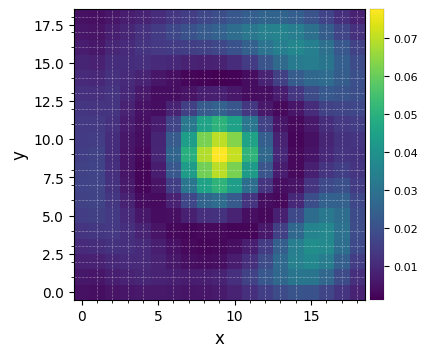

In [19]:
plot_frames(psfn, grid=True, size_factor=4)

In [50]:
help(throughput)

Help on function throughput in module vip_hci.metrics.contrcurve:

throughput(cube, angle_list, psf_template, fwhm, algo, nbranch=1, theta=0, inner_rad=1, fc_rad_sep=3, wedge=(0, 360), fc_snr=100, full_output=False, verbose=True, **algo_dict)
    Measures the throughput for chosen algorithm and input dataset (ADI or
    ADI+mSDI). The final throughput is the average of the same procedure
    measured in ``nbranch`` azimutally equidistant branches.
    
    Parameters
    ---------_
    cube : 3d or 4d numpy ndarray
        The input cube, 3d (ADI data) or 4d array (IFS data), without fake
        companions.
    angle_list : 1d numpy ndarray
        Vector with parallactic angles.
    psf_template : 2d or 3d numpy ndarray
        Frame with the psf template for the fake companion(s).
        PSF must be centered in array. Normalization is done internally.
    fwhm: int or float or 1d array, optional
        The the Full Width Half Maximum in pixels. It can handle a different
        FW

In [12]:
res_thr = throughput(cube, angle, psfn, fwhm_sphere, ncomp=15,
                     algo=pca, nbranch=1, full_output=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-04-16 09:54:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube without fake companions processed with pca
Running time:  0:04:37.443946
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Measured annulus-wise noise in resulting frame
Running time:  0:04:38.922402
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Flux in 1xFWHM aperture: 1.000
Fake companions injected in branch 1 (pattern 1/3)
Running time:  0:04:57.495562
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube with fake companions processed with pca
Measuring its annulus-wise throughput
Running time:  0:09:16.816090
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Fake companions injected in branch 1 (pattern 2/3)
Running time:  0:09:33.879042
――――――――――――――――――

Text(0.5, 0, 'separation in pixels')

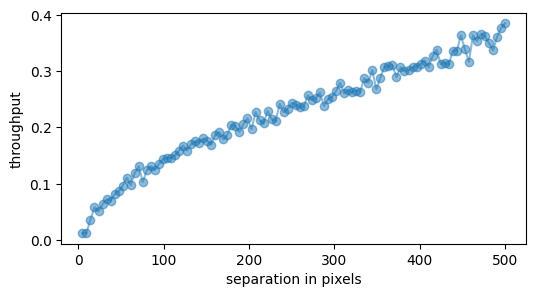

In [13]:
figure(figsize=(6,3))
plot(res_thr[3], res_thr[0][0,:], 'o-', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')

### Contrast curves

In [15]:
nsig=5

In [51]:
mas = 12.27 * u.mas
arcsec = mas.to(u.arcsec)

In [ ]:
cc_1 = contrast_curve(cube, angle, psfn, fwhm=fwhm_sphere, pxscale=arcsec, starphot=12258,
                      sigma=nsig, nbranch=1, algo=pca, ncomp=9, debug=True)

In [28]:
help(pixel_scale)

NameError: name 'pixel_scale' is not defined

In [36]:
help(u.pixel_scale)

Help on function pixel_scale in module astropy.units.equivalencies:

pixel_scale(pixscale)
    Convert between pixel distances (in units of ``pix``) and other units,
    given a particular ``pixscale``.
    
    Parameters
    ----------
    pixscale : `~astropy.units.Quantity`
        The pixel scale either in units of <unit>/pixel or pixel/<unit>.



In [46]:
mas = 12.25 * u.mas
arcsec = mas.to(u.arcsec)

In [48]:
arcsec

<Quantity 0.01225 arcsec>